In [ ]:
# reference to: https://github.com/MikhailMurashov/ecgGAN/blob/master/ecgGAN.ipynb

%matplotlib inline
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
from keras.models import Model
from keras.layers import Input, Reshape
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling1D, Conv1D
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam, SGD
from keras.callbacks import TensorBoard
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Dense, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import initializers
# 사용할 라이브러리 선언
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

from tensorflow.keras import layers
#for data preprocessing
from sklearn.decomposition import PCA

#for modeling
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split #training and testing data split
from keras.layers import Input, Dense
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from sklearn.preprocessing import StandardScaler
#filter warnings
import warnings

# 우리의 랜덤 노이즈 벡터의 차원을 설정합니다.
random_dim = 121

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, regularizers
import torch

import matplotlib.pyplot as plt
import numpy as np
import random

from IPython import display
from tqdm import tqdm
from shutil import copyfile


print(tf.__version__)


# from google.colab import drive
# drive.mount('/drive')


norm_value = 2173


#################################################################################
#          Helper functions
#################################################################################
def test_show(generator, discriminator):
    noise = tf.random.normal([1, 125, 50])
    generated_ecg = generator(noise, training=False)
    print(generated_ecg.shape)
    plt.plot(generated_ecg[0, 0, :])
    plt.show()
    
    decision = discriminator(generated_ecg, training=False)
    print(decision)
    

def generate_and_save_ecg(model, epoch, test_input, save):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,3))
    plt.plot(predictions[0, 0, :] * norm_value)
    # plt.plot(predictions[0, 0, :])
    
    if save:
        plt.savefig('./ecg_at_epoch_{:04d}.png'.format(epoch))

    plt.show()
    

def prepare_data(dim):
#     copyfile(f"/drive/My Drive/Colab Notebooks/data/fix_signals_400.npy", "./fix_signals.npy")

    data = pd.read_csv("/content/drive/My Drive/merge_real_total.csv",header=None)
    data = data.iloc[:,0:120]
    print(data.shape)
    data = np.reshape(data.to_numpy(), (data.to_numpy().shape[0], 1, data.to_numpy().shape[1]))
    print('Data shape:', data.shape)

    data = data / norm_value # Normalize
    data = np.array(data, dtype='float32')

    plt.figure(figsize=(4,3))
    plt.plot(data[random.randint(0, data.shape[0])][0] * norm_value)
    plt.show()

    train_size = int(data.shape[0] * 0.9)
    test_size = data.shape[0] - train_size
    print(train_size, test_size)

    # Batch and shuffle the data
    train_dataset = tf.data.Dataset.from_tensor_slices(data[:train_size]).shuffle(train_size).batch(BATCH_SIZE)
    test_dataset  = tf.data.Dataset.from_tensor_slices(data[train_size:]).shuffle(test_size).batch(1)

    seed = tf.random.normal(dim)
    
    return seed, train_dataset, test_dataset

2.4.0


In [ ]:

def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Input(shape=(30, 120)))

    model.add(layers.Bidirectional(layers.LSTM(64, return_sequences=True)))

    model.add(layers.Conv1D(filters=128, kernel_size=16, strides=1, padding='same'))
    model.add(layers.LeakyReLU())
  
    model.add(layers.Conv1D(filters=64, kernel_size=16, strides=1, padding='same'))
    model.add(layers.LeakyReLU())
    
    model.add(layers.UpSampling1D(2))
    
    model.add(layers.Conv1D(filters=32, kernel_size=16, strides=1, padding='same'))
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv1D(filters=16, kernel_size=16, strides=1, padding='same'))
    model.add(layers.LeakyReLU())

    model.add(layers.UpSampling1D(2))
    
    model.add(layers.Conv1D(filters=1, kernel_size=16, strides=1, padding='same', activation='tanh'))
    
    model.add(layers.Permute((2, 1)))
    
    return model


def make_discriminator_model():
    model = tf.keras.Sequential()
   
    model.add(layers.Input(shape=(1, 120)))
    model.add(layers.Permute((2, 1)))
    
    model.add(layers.Conv1D(filters=32, kernel_size=16, strides=1, padding='same'))
    model.add(layers.LeakyReLU())

    # model.add(layers.Dropout(0.4))

    model.add(layers.Conv1D(filters=64, kernel_size=16, strides=1, padding='same'))
    model.add(layers.LeakyReLU())

    model.add(layers.MaxPool1D(pool_size=2))

    model.add(layers.Conv1D(filters=128, kernel_size=16, strides=1, padding='same'))
    model.add(layers.LeakyReLU())

    # model.add(layers.Dropout(0.4))

    model.add(layers.Conv1D(filters=256, kernel_size=16, strides=1, padding='same'))
    model.add(layers.LeakyReLU())

    model.add(layers.MaxPool1D(pool_size=2))

    #model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

generator     = make_generator_model()
discriminator = make_discriminator_model()
    
generator.summary()
discriminator.summary()

# test_show(generator, discriminator)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 30, 128)           94720     
_________________________________________________________________
conv1d (Conv1D)              (None, 30, 128)           262272    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 30, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 30, 64)            131136    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 30, 64)            0         
_________________________________________________________________
up_sampling1d (UpSampling1D) (None, 60, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 60, 32)            3

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers.core import Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Flatten
from keras.optimizers import SGD
from keras.datasets import mnist
import numpy as np
from PIL import Image
import argparse
import math


def generator_model():
    model = Sequential()
    model.add(Dense(input_dim=(100,

TypeError: ignored

(92673, 120)
Data shape: (92673, 1, 120)


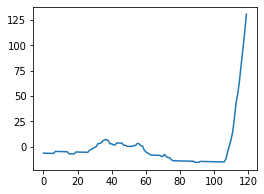

83405 9268


In [ ]:
    BATCH_SIZE = 400
    norm_value = 2173
    data = pd.read_csv("/content/drive/My Drive/merge_real_total.csv",header=None)
    data = data.iloc[:,0:120]
    print(data.shape)
    data = np.reshape(data.to_numpy(), (data.to_numpy().shape[0], 1, data.to_numpy().shape[1]))
    print('Data shape:', data.shape)

    data = data / norm_value # Normalize
    data = np.array(data, dtype='float32')

    plt.figure(figsize=(4,3))
    plt.plot(data[random.randint(0, data.shape[0])][0] * norm_value)
    plt.show()

    train_size = int(data.shape[0] * 0.9)
    test_size = data.shape[0] - train_size
    print(train_size, test_size)

    # Batch and shuffle the data
    train_dataset_paf = tf.data.Dataset.from_tensor_slices(data[:train_size]).shuffle(train_size).batch(BATCH_SIZE)
    test_dataset_paf = tf.data.Dataset.from_tensor_slices(data[train_size:]).shuffle(test_size).batch(1)

In [ ]:
#################################################################################
#          Prepare metrics for logging
#################################################################################

# !rm -rf ./logs/

### discriminator loss ###
# disc_log_dir = 'logs/gradient_tape/disc_loss'
# disc_summary_writer = tf.summary.create_file_writer(disc_log_dir)
disc_losses = tf.keras.metrics.Mean('disc_loss', dtype=tf.float32)
disc_losses_list = []

### discriminator accuracy ###
fake_disc_accuracy = tf.keras.metrics.BinaryAccuracy('fake_disc_accuracy')
real_disc_accuracy = tf.keras.metrics.BinaryAccuracy('real_disc_accuracy')
fake_disc_accuracy_list, real_disc_accuracy_list = [], []

### generator loss ###
# gen_log_dir = 'logs/gradient_tape/gen_loss'
# gen_summary_writer = tf.summary.create_file_writer(gen_log_dir)
gen_losses = tf.keras.metrics.Mean('gen_loss', dtype=tf.float32)
gen_losses_list = []


#################################################################################
#          Prepare loss functions and optimizers
#################################################################################

# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(0.0002)
discriminator_optimizer = tf.keras.optimizers.Adam(0.0002)

In [ ]:
disc_steps = 1

# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(real_ecg, dim):
    print('hello??')
    noise = tf.random.normal(dim)

    for i in range(disc_steps):
        with tf.GradientTape() as disc_tape:
            generated_ecg = generator(noise, training=True)
            real_output = discriminator(real_ecg, training=True)
            fake_output = discriminator(generated_ecg, training=True)
            disc_loss = discriminator_loss(real_output, fake_output)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
        
        ### for tensorboard ###
        disc_losses.update_state(disc_loss)
        fake_disc_accuracy.update_state(tf.zeros_like(fake_output), fake_output)
        real_disc_accuracy.update_state(tf.ones_like(real_output), real_output)
        #######################
    
    with tf.GradientTape() as gen_tape:
        generated_ecg = generator(noise, training=True)
        fake_output = discriminator(generated_ecg, training=True)

        gen_loss = generator_loss(fake_output)
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

    ### for tensorboard ###
    gen_losses.update_state(gen_loss)
    #######################
    

def train(dataset, epochs, dim):
    for epoch in tqdm(range(epochs)):
    
        for batch in dataset:
            #print(batch)
            train_step(batch, dim)
            
        disc_losses_list.append(disc_losses.result().numpy())
        gen_losses_list.append(gen_losses.result().numpy())
        
        fake_disc_accuracy_list.append(fake_disc_accuracy.result().numpy())
        real_disc_accuracy_list.append(real_disc_accuracy.result().numpy())
        
        ### for tensorboard ###
#         with disc_summary_writer.as_default():
#             tf.summary.scalar('loss', disc_losses.result(), step=epoch)
#             tf.summary.scalar('fake_accuracy', fake_disc_accuracy.result(), step=epoch)
#             tf.summary.scalar('real_accuracy', real_disc_accuracy.result(), step=epoch)
            
#         with gen_summary_writer.as_default():
#             tf.summary.scalar('loss', gen_losses.result(), step=epoch)
            
        disc_losses.reset_states()        
        gen_losses.reset_states()
        
        fake_disc_accuracy.reset_states()
        real_disc_accuracy.reset_states()
        #######################

        # Save the model every 5 epochs
#         if (epoch + 1) % 5 == 0:
#             generate_and_save_ecg(generator, epochs, seed, False)
#             checkpoint.save(file_prefix = checkpoint_prefix)

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_ecg(generator, epochs, seed, False)
    
    model_json = generator.to_json() 
    with open("/content/drive/My Drive/ecggan_10.json", "w") as json_file: 
      json_file.write(model_json)
    generator.save_weights("/content/drive/My Drive/ecggan_10.h5") 
    print("Saved model to disk")


(92673, 120)
Data shape: (92673, 1, 120)


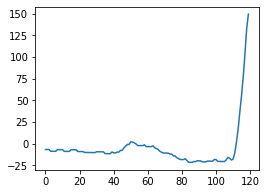

83405 9268


In [ ]:
BATCH_SIZE = 128
noise_dim = [BATCH_SIZE, 30, 120]

seed, train_dataset, test_dataset = prepare_data(noise_dim)

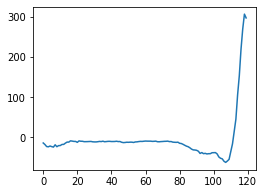

Saved model to disk


In [ ]:
train(train_dataset, 10, noise_dim)
generator.save('/content/drive/My Drive/generator_10.h5')
discriminator.save('/content/drive/My Drive/discriminator_10.h5')

In [ ]:
generator.save('/content/drive/My Drive/generator_10.h5')
discriminator.save('/content/drive/My Drive/discriminator_10.h5')

NameError: ignored

In [ ]:
model = tf.keras.models.load_model('/content/drive/My Drive/generator_80e_dropout.h5')

In [ ]:

#################################################################################
#          Testing functions
#################################################################################
import sklearn
def rmse(targets, predictions):
    return np.sqrt(np.mean((targets-predictions)**2))


def prd(targets, predictions):
    s1 = np.sum((targets-predictions)**2)
    s2 = np.sum(targets**2)
    return np.sqrt(s1 / s2 * 100)


def testing(test_dataset, model, noise_dim):
    noise = tf.random.normal(noise_dim)
    generated_ecgs = model(noise, training=False)
    mmd_sum, prd_sum, rmse_sum = [], [], []
    really = pd.DataFrame()
    faking = pd.DataFrame()
    j=0
    for true_ecg, gen_ecg in zip(test_dataset, generated_ecgs):
        prd_sum.append(prd(true_ecg[0][0], gen_ecg[0]))
        rmse_sum.append(rmse(true_ecg[0][0], gen_ecg[0]))
        really[j] = true_ecg[0][0]
        faking[j] = gen_ecg[0]
        j = j+1
    
    really = np.transpose(really)
    faking = np.transpose(faking)
    print(really.shape)
    print('prd :', f'mean={np.mean(prd_sum):.4f}', f'min={np.min(prd_sum):.4f}', f'max={np.max(prd_sum):.4f}')
    print('rmse:', f'mean={np.mean(rmse_sum):.4f}', f'min={np.min(rmse_sum):.4f}', f'max={np.max(rmse_sum):.4f}')


    x_sk=sklearn.metrics.pairwise.cosine_similarity(really, faking, dense_output=True)
    # print(x_sk)
    print(x_sk.mean())

In [ ]:
    """
    noise_dim = [9268,30,120]
    noise = tf.random.normal(noise_dim)
    generated_ecgs = model(noise, training=False)
    mmd_sum, prd_sum, rmse_sum = [], [], []
    really = pd.DataFrame()
    faking = pd.DataFrame()
    j=0
    for true_ecg, gen_ecg in zip(test_dataset, generated_ecgs):
        really[j] = true_ecg[0][0]
        faking[j] = gen_ecg[0]
        j = j+1
    
    really = np.transpose(really)
    faking = np.transpose(faking)
    x_sk=sklearn.metrics.pairwise.cosine_similarity(really, faking, dense_output=True)
    # print(x_sk)
    print(x_sk.mean())
    """
testing(test_dataset, model, [9268, 30, 120])

(9268, 120)
prd : mean=10.7985 min=2.1683 max=86.7554
rmse: mean=0.0081 min=0.0017 max=0.1559
0.6756555


In [ ]:
"""
    noise_dim = [9268,30,120]
    noise = tf.random.normal(noise_dim)
    generated_ecgs = model(noise, training=False)
    mmd_sum, prd_sum, rmse_sum = [], [], []
    really = pd.DataFrame()
    faking_paf = pd.DataFrame()
    j=0
    for true_ecg, gen_ecg in zip(test_dataset, generated_ecgs):
        really[j] = true_ecg[0][0]
        faking_paf[j] = gen_ecg[0]
        j = j+1
    
    really = np.transpose(really)
    faking_paf = np.transpose(faking_paf)
    x_sk=sklearn.metrics.pairwise.cosine_similarity(really, faking_paf, dense_output=True)
    # print(x_sk)
    print(x_sk.mean())
"""
testing(test_dataset, model, [9268, 30, 120])

(9268, 120)
prd : mean=10.3725 min=2.3296 max=60.6107
rmse: mean=0.0131 min=0.0020 max=0.1126
0.5793158


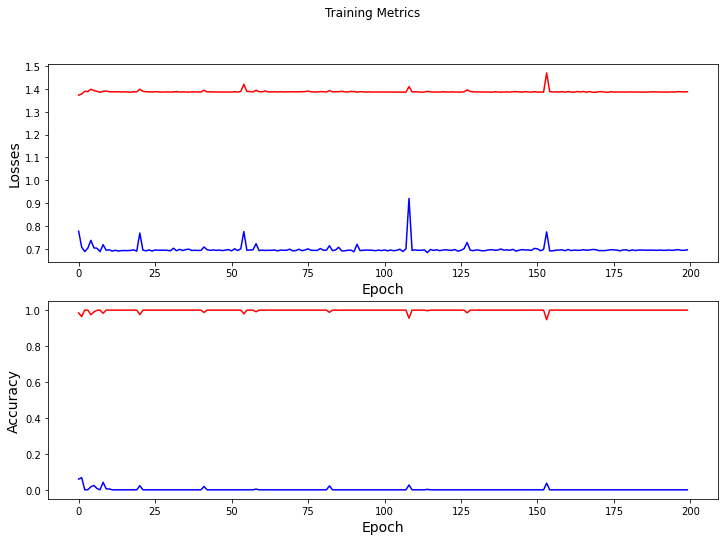

In [ ]:

# %reload_ext tensorboard
# %tensorboard --logdir logs/gradient_tape

fig, axes = plt.subplots(2, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Losses", fontsize=14)
axes[0].set_xlabel("Epoch", fontsize=14)
axes[0].plot(disc_losses_list, color='red')
axes[0].plot(gen_losses_list, color='blue')

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(fake_disc_accuracy_list, color='red')
axes[1].plot(real_disc_accuracy_list, color='blue')
plt.show()

In [ ]:

x_sk=sklearn.metrics.pairwise.cosine_similarity(faking, faking_paf, dense_output=True)
print(x_sk.mean())

0.9939093


In [ ]:
from tensorflow.compat.v2.keras.models import model_from_json


json_file = open("/content/drive/My Drive/generator_80e_dropout.json", "r") 
loaded_model_json = json_file.read() 
json_file.close()

loaded_model = model_from_json(loaded_model_json)

loaded_model.load_weights("/content/drive/My Drive/generator_80e_dropout.h5") 
print("Loaded model from disk")

FileNotFoundError: ignored

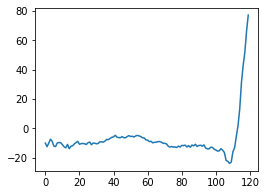

In [ ]:
display.clear_output(wait=True)
generate_and_save_ecg(model, 1, seed, False)

In [ ]:
generated_images2 = loaded_model.predict(test_dataset)

NameError: ignored

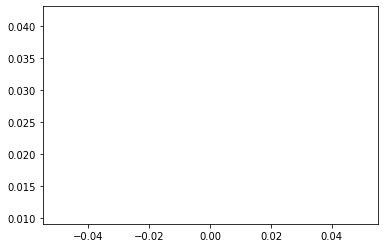

In [ ]:
plt.plot(generated_images2[1,:])

In [ ]:
import sklearn
x_sk=sklearn.metrics.pairwise.cosine_similarity(test_dataset.to_numpy(), generated_images2, dense_output=True)
# print(x_sk)
print(x_sk.mean())
x_sk=sklearn.metrics.pairwise.cosine_similarity(test_dataset.to_numpy(), generated_images22, dense_output=True)
# print(x_sk)
print(x_sk.mean())

AttributeError: ignored

In [ ]:
import sklearn
x_sk=sklearn.metrics.pairwise.cosine_similarity(generated_images2, generated_images22, dense_output=True)